# Simulations modèle ICSV

In [1]:
import vocal_tract_constrained as vc
from simulations_test.body_vocal_tract import *
from simulations_test.terminal_impedance import *

import pyphs as phs
import sympy as sy
import numpy as np
import os

import datetime
import pickle
import sympy as sy
import matplotlib.pyplot as plt
from scipy.io.wavfile import write as wavWrite
import h5py
sy.init_printing()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

PPTY_PHY_PARAMS = {"positive": True, "real" : True }                            
PPTY_STATE_VAR  = {"real" : True }

In [2]:
phs.__version__
IMPULSE_RESPONSE = True

## Instanciation de l'objet `core`
On considère que la largeur $L$ est égale à la hauteur au repos $h_0$ pour un tronçon donné.

Pour la voyelle A, on prend $A_1 = \frac{1}{10} A_2$ avec $A_i$ l'aire de la section du tronçon $i=1,2$.

V_0_1 : 1.4e-05
V_0_2 : 1.4e-05
V_0_3 : 1.4e-05
V_0_4 : 1.4e-05
V_0_5 : 1.4e-05
Computing equations pour N = 5...


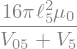

Done !


In [3]:
N_tube       = 5
label        = 'vocal_tract'
forme_model  = 'quad_comp_shift'
total_length = 0.175

h = 0.02 
L = h


h_ray = 0.8
Sray = (h_ray)**2

VT_subs = {
        'P_0'     : 101.325e03,
        'rho_0'     : 1.225,
        'gamma'     : 1.4,
        'Z_ray'     : 128/(9*Sray),
        }

# Calcul des V0
for i in range(N_tube): # V = 2 * ell * L * h
    ind = str(i+1)
    VT_subs["ell_" + ind] = total_length/(2*N_tube)
    VT_subs["L_" + ind]   = L
    Sw                    = 2*VT_subs['ell_' + ind]*L
    VT_subs["V_0_" + ind] = Sw*h
    print("V_0_{0} : {1}".format(i+1, VT_subs["V_0_" + ind]))

# Assemblage des dictionnaires
VT_subs_tot = dict(VT_subs)

core = vc.VocalTractLumpedParameter(
                                    N     = N_tube,
                                    label = label,
                                    mode  = forme_model,
                                    **VT_subs_tot,
                                    )

assert not core.freesymbols(), 'Il manque des valeurs/échelles'

In [4]:
# ajout de ressort dans la paroi
body = []
    
for i in range(N_tube):
    body.append(DissipativeSingleSpringBody(n=i+1))
    core = core +  body[i]
    core.add_connector((2, core.y.index(body[i].y[0])), alpha=-1)
    

# ajout d'une impédance de rayonnement
composant_impedance = RadiationImpedance()
core = core + composant_impedance
core.add_connector((1, core.y.index(composant_impedance.y[0])), alpha=1)


core.connect()

In [5]:
## Update subs
body_subs = {}

for i in range(1,N_tube+1):    
    body_subs['k_' + str(i)] = 845
    body_subs['r_' + str(i)] = 0.8

core.subs.update(                                                       
    {core.symbols(k,**PPTY_PHY_PARAMS): v for k, v in body_subs.items()}   
)